# Bayesian Estimation of Position and Velocity

This notebook demonstrates how to estimate the position and velocity of an object using Bayesian inference with the `emcee` library.

In [1]:
# Install the necessary libraries
# emcee: for MCMC sampling
# corner: for visualizing the posterior distributions
!pip install emcee

In [2]:
# cornerHDR: corner library with extra functions
url = f"https://raw.githubusercontent.com/jsuarez314/bayesian-ml-physics-lab/refs/heads/main/src/cornerHDR.py"
!wget -nc {url}

File ‘cornerHDR.py’ already there; not retrieving.



In [3]:
# Import the necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import emcee
import cornerHDR

## Position Bayes model

The position of the oscillating fluid in the U-tube experiment is modeled by a damped sinusoidal function:

$$x(t) = a \exp(-b t) \sin(c t + d) + e$$

Here, the parameters represent key physical characteristics of the oscillation:

- $a$: Amplitude at time $t=0$. This represents the initial displacement from the equilibrium position before damping reduces the oscillation magnitude.
- $b$: Damping coefficient. This parameter quantifies how quickly the amplitude of the oscillation decays over time due to dissipative forces like viscosity and air resistance. A larger value of $b$ indicates faster damping.
- $c$: Angular frequency. This parameter is related to the period of the oscillation ($T = 2\pi/c$) and the natural frequency of the system. It is influenced by the physical properties of the U-tube and the fluid.
- $d$: Phase offset. This parameter accounts for the initial phase of the oscillation at $t=0$. It shifts the sinusoidal function along the time axis.
- $e$: Vertical offset. This parameter represents a potential constant displacement of the equilibrium position from zero, which could be due to factors like measurement calibration or a slight tilt of the U-tube.

By fitting this model to the experimental position data, we can extract these physical parameters and quantify their uncertainties using Bayesian inference.

In [4]:
# Position Estimation

# Load the experimental data from the repository
data_url = 'https://raw.githubusercontent.com/jsuarez314/bayesian-ml-physics-lab/refs/heads/main/data/U1.txt'
!wget -nc {data_url}
pathfile = 'U1.txt'
data = np.loadtxt(pathfile)

File ‘U1.txt’ already there; not retrieving.



In [5]:
# Define the model function for the position
# This is a sinusoidal function with an exponential decay
def model(x, a, b, c, d, e):
    return a * np.exp(-b * x) * np.sin(c * x + d) + e

# Define the log prior function
# This function defines the prior probability distribution for each parameter
# We use uniform priors within specified ranges
def log_prior(params):
    a, b, c, d, e = params
    if 0.01 < a < 1 and 0.01 < b < 11 and 5 < c < 15 and -10 < d < -5 and -1 < e < -0.001:
        return 0.0  # Log of probability 1 is 0
    return -np.inf  # Log of probability 0 is -infinity

# Define the log probability function
# This function combines the log prior and the log likelihood
def log_probability(params, x, y, yerr):
    # Calculate the log prior
    prior = log_prior(params)
    # If the prior is not finite, the log probability is also not finite
    if not np.isfinite(prior):
        return -np.inf

    # Calculate the model prediction for the given parameters
    y_model = model(x, *params)
    # Calculate the chi-squared value
    chi_squared = np.sum(((y - y_model) / yerr) ** 2)
    # Calculate the log likelihood
    log_likelihood = -0.5 * chi_squared

    # Return the sum of the log prior and log likelihood
    return prior + log_likelihood

# Observed data for position
t = data[:, 0]  # Time data
x = data[:, 1]  # Position data
xerr = 0.001  # Error in the position data

# Initial guess for the model parameters
initial_guess = [0.02, 0.5, 10.0, -7.0, -0.003]

# Set the number of walkers and dimensions for the MCMC
nwalkers = 700
ndim = len(initial_guess)

# Generate an initial random sample of parameters for the walkers
pos = initial_guess + 1e-4 * np.random.randn(nwalkers, ndim)

# Create the EnsembleSampler object from emcee
# This object will run the MCMC sampling
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(t, x, xerr), moves=emcee.moves.StretchMove(a=0.1))

# Run the MCMC for a "burn-in" phase to let the walkers settle
n_burnin_steps = 500
pos, _, _ = sampler.run_mcmc(pos, n_burnin_steps)

# Reset the sampler to clear the burn-in samples
sampler.reset()

# Run the main MCMC sampling
n_steps = 10000
sampler.run_mcmc(pos, n_steps, progress=True)

# Get the chains of samples generated by the sampling
samples = sampler.get_chain()

# Flatten the samples, discarding the first 100 as a final burn-in and thinning by 15
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

# Display the fitted parameter values and their uncertainties
fitted_parameters = []
for i in range(ndim):
    # Calculate the 16th, 50th, and 84th percentiles of the samples for each parameter
    mcmc_result = np.percentile(flat_samples[:, i], [16, 50, 84])
    # The 50th percentile is the median, which we take as the fitted value
    fitted_parameters.append(mcmc_result[1])
    # Print the fitted value and the uncertainties
    print(f"Parameter {i+1}: {mcmc_result[1]:.2e} +{mcmc_result[2]-mcmc_result[1]:.2e} -{mcmc_result[1]-mcmc_result[0]:.2e}")

# Unpack the fitted parameters for later use
pa, pb, pc, pd, pe = fitted_parameters

100%|██████████| 10000/10000 [05:16<00:00, 31.57it/s]


Parameter 1: 2.71e-02 +4.12e-04 -4.12e-04
Parameter 2: 5.64e-01 +1.10e-02 -1.09e-02
Parameter 3: 1.06e+01 +1.30e-02 -1.30e-02
Parameter 4: -7.45e+00 +1.54e-02 -1.54e-02
Parameter 5: -3.61e-03 +6.60e-05 -6.62e-05


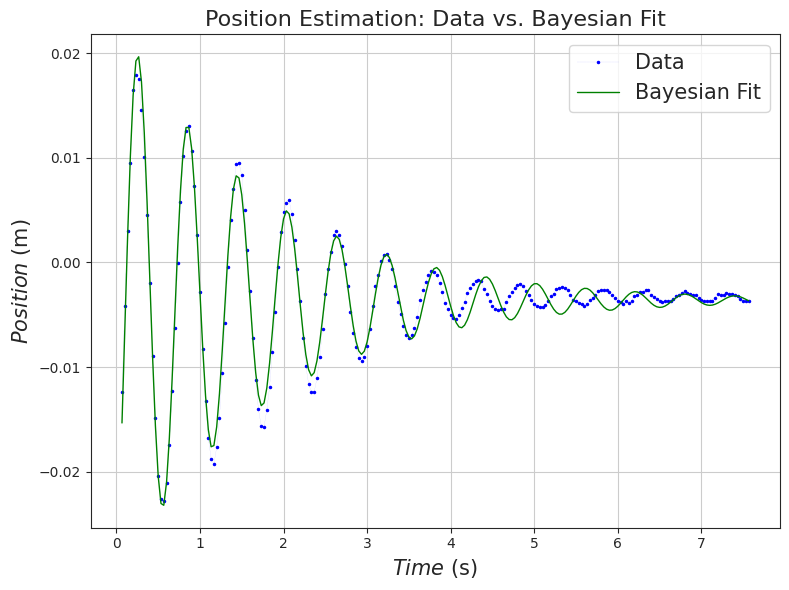

In [6]:
# Plot the data and the Bayesian fit for position

# Calculate the theoretical position using the fitted parameters
xbayes = pa * np.exp(-pb * t) * np.sin(pc * t + pd) + pe

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(t, x, color='blue', label='Data', marker='.', markersize=3.0, linewidth=0.05, ls='--')
plt.plot(t, xbayes, color='green', linewidth=1, label='Bayesian Fit')

# Set the labels and title
plt.xlabel(r'$Time$ (s)', fontsize=15)
plt.ylabel(r'$Position$ (m)', fontsize=15)
plt.title('Position Estimation: Data vs. Bayesian Fit', fontsize=16)
plt.legend(loc='upper right', fontsize=15)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

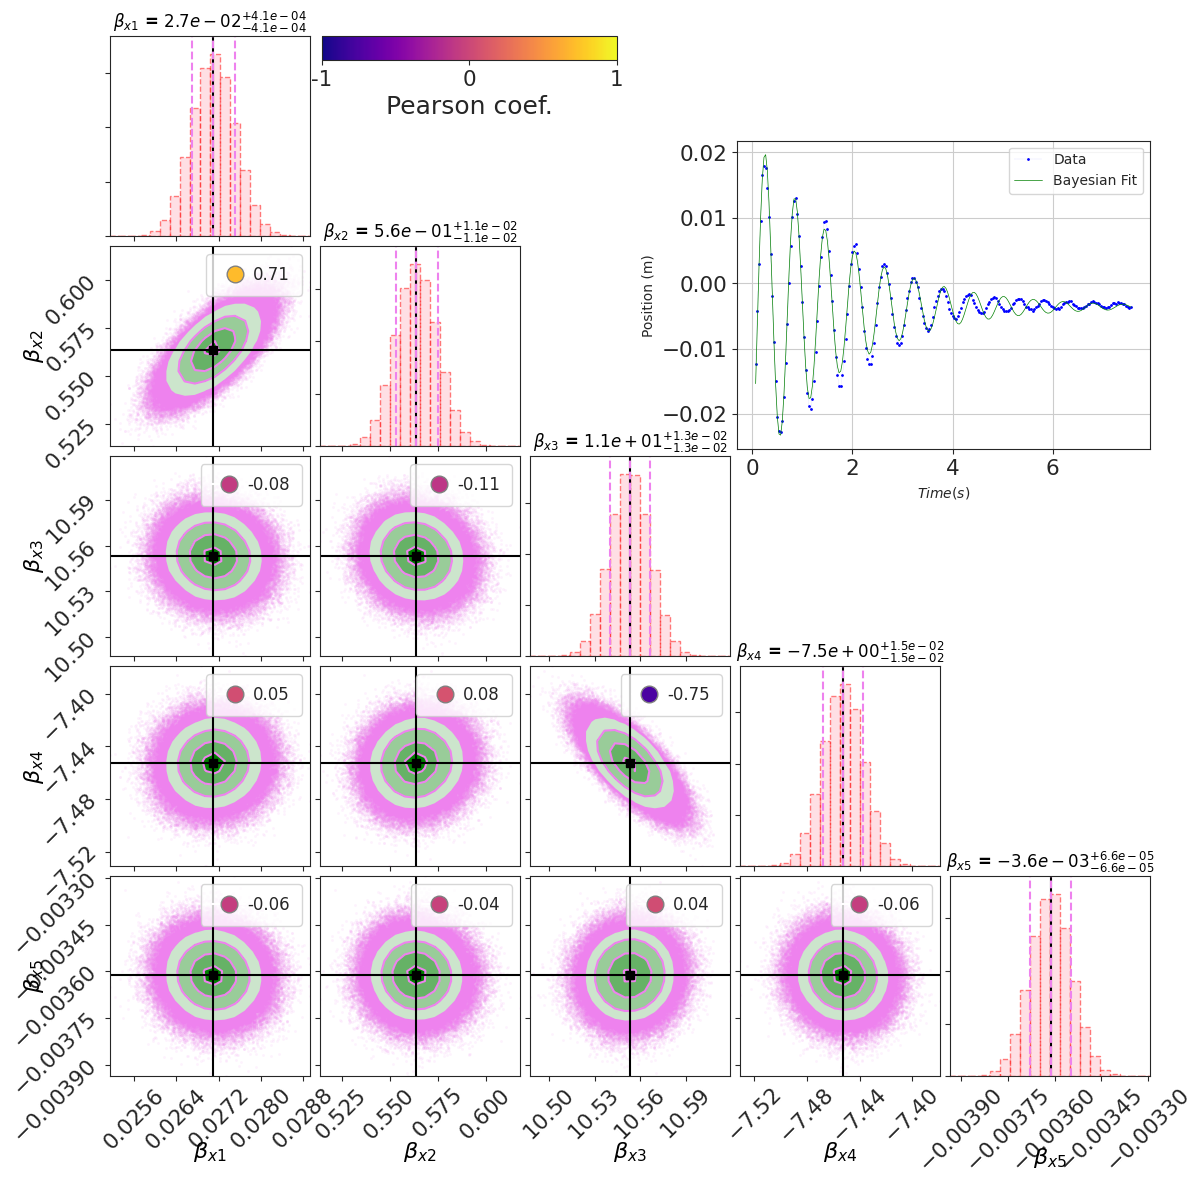

In [7]:
# Create a corner plot to visualize the posterior distributions of the position parameters

# Get the median of the fitted parameters
medians = np.array(fitted_parameters)
medians_list = medians.tolist()

# Define the labels for the parameters
labels = [r'$\beta_{x1}$', r'$\beta_{x2}$', r'$\beta_{x3}$', r'$\beta_{x4}$',r'$\beta_{x5}$']
label_kwargs = {"fontsize": 16, "color": "black", "fontweight": "bold"}

# Create the corner plot
fig = cornerHDR.corner(flat_samples, labels=labels, quantiles=[0.16, 0.5, 0.84],
    color="violet",
    show_titles=True,
    add_pvalue=True,
    plot_density=True,
    plot_contours=True,
    smooth=1.0,
    max_n_ticks=5,
    use_math_text=True,
    fill_contours=True,
    truths= medians_list,
    truth_color="black",
    title_fmt='.1e',
    color_hist="violet",color_dens="green",
    group="posterior",
    label_kwargs=label_kwargs,
    hist_kwargs={"color": "pink","edgecolor": "red","linestyle":"dashed", "linewidth": 1,"alpha": 0.5,"histtype":"barstacked"},
    title_kwargs={"fontsize": 12,"color": "Black", "fontweight": "bold"})

# Add an inset plot showing the data and the fit
ax = plt.subplot2grid((10, 10), (1, 6), rowspan=3, colspan=4)
ax.plot(t, x, color='blue', label='Data', marker='.', markersize=2.0, linewidth=0.05, ls='--')
ax.plot(t, xbayes, color='green', linewidth=0.5, label='Bayesian Fit')
ax.set_xlabel(r'$Time (s)$')
ax.set_ylabel(r'Position (m)')
ax.legend()
ax.grid(True)

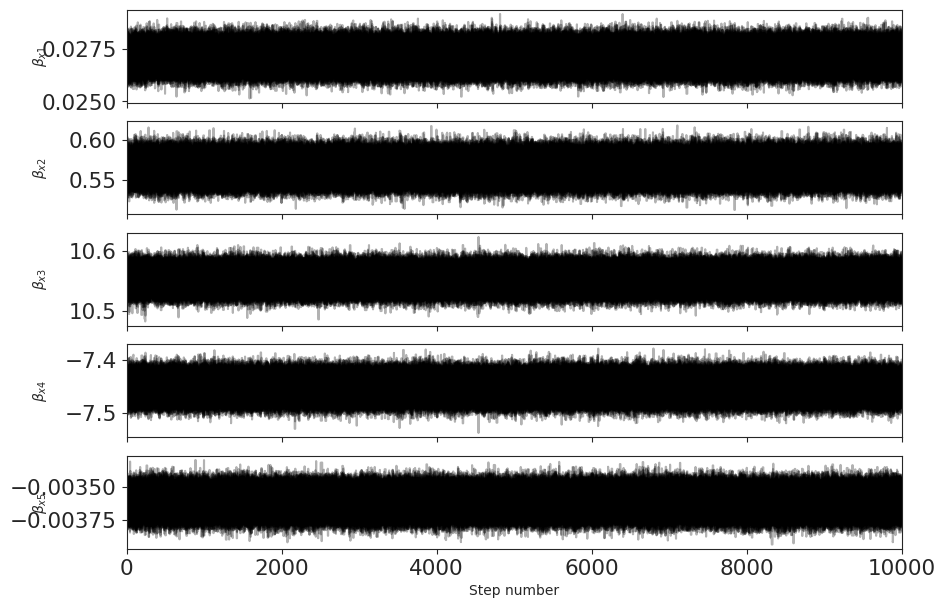

In [8]:
# Create a trace plot to diagnose the convergence of the MCMC chains for the position parameters

# Create a figure with subplots for each parameter
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
labels = [r'$\beta_{x1}$', r'$\beta_{x2}$', r'$\beta_{x3}$', r'$\beta_{x4}$', r'$\beta_{x5}$']

# Plot the samples for each walker over the steps
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

# Set the x-label for the last subplot
axes[-1].set_xlabel("Step number")
plt.show()

## Velocity Bayes model

The velocity of the oscillating fluid in the U-tube experiment is obtained as the time derivative of the position function.  
Differentiating $x(t) = a e^{-b t} \sin(c t + d) + e $ yields:

$$ v(t) = a e^{-b t} [c \cos(c t + d) - b \sin(c t + d)]$$.

This expression describes how the fluid's velocity evolves over time as it oscillates around the equilibrium position while losing energy due to damping.  
Each parameter retains its physical meaning from the position model, but their combined effect on the velocity provides complementary insight:

- $a$: Determines the initial amplitude of motion and scales the overall magnitude of the velocity.  
- $b$: *Damping coefficient.* It controls how quickly the velocity amplitude decreases over time. A larger \( b \) leads to faster decay, reducing the system's kinetic energy more rapidly.  
- $c$: *Angular frequency.* It defines the oscillation rate of the velocity; the velocity and position are phase-shifted by \( \pi/2 \).  
- $d$: *Phase offset.* It sets the initial timing of the oscillation, affecting whether the motion starts near maximum velocity or near rest.  
- $e$: The *vertical offset* from the position model does not directly influence the velocity, since its derivative is zero.

By analyzing this velocity model, we can study not only the damping behavior but also the energy exchange between kinetic and potential forms in the oscillating fluid.  

This representation provides a more dynamic perspective on the system's physical parameters and helps validate the consistency of the Bayesian parameter estimation.


In [9]:
# Velocity Estimation

# Load the data (can be reused from the position estimation)
data_vel = np.loadtxt('U1.txt')

# Define the model function for velocity
# This is the derivative of the position model
def vel_model(x, k, l, m, n):
    """A model for velocity."""
    return k * np.exp(-l * x) * (m * np.cos(m * x + n) - l * np.sin(m * x + n))

# Define the log prior function for velocity parameters
def log_prior_vel(params):
    """
    Log of the prior probability distribution for velocity parameters.
    Defines uniform priors for each parameter in specific ranges.
    """
    k, l, m, n = params
    # We use the information from the position estimation to set the priors
    # For example, the prior for 'l' is centered around the fitted value 'pd'
    if pa*0.9 < k < pa*1.1 and pb*0.9 < l < pb*1.1 and pc*0.9 < m < pc*1.1 and pd*0.9 < n < pd*1.1:
        return 0.0
    return -np.inf

# Define the log probability function for velocity
def log_probability_vel(params, x, y, yerr):
    """
    Log of the posterior probability distribution for velocity.
    Combines the prior and the likelihood.
    """
    prior = log_prior_vel(params)
    if not np.isfinite(prior):
        return -np.inf

    y_model = vel_model(x, *params)
    chi_squared = np.sum(((y - y_model) / yerr) ** 2)
    log_likelihood = -0.5 * chi_squared

    return prior + log_likelihood

# Observed data for velocity
t = data_vel[:, 0]  # Time data
v = data_vel[:, 2]  # Velocity data
verr = 0.001  # Error in the velocity data

# Initial guess for the velocity model parameters, informed by the position fit
initial_guess_vel = [pa, pb, pc, pd]

# Set the number of walkers and dimensions for the MCMC
nwalkers_vel = 700
ndim_vel = len(initial_guess_vel)

# Generate an initial random sample of parameters for the walkers
pos_vel = initial_guess_vel + 1e-4 * np.random.randn(nwalkers_vel, ndim_vel)

# Create the sampler object for velocity
sampler_vel = emcee.EnsembleSampler(nwalkers_vel, ndim_vel, log_probability_vel, args=(t, v, verr), moves=emcee.moves.StretchMove(a=0.1))

# Run MCMC for the burn-in phase
sampler_vel.run_mcmc(pos_vel, n_burnin_steps)

# Reset the chains for the post-burn-in sampling phase
sampler_vel.reset()

# Run the main MCMC sampling for velocity
sampler_vel.run_mcmc(pos_vel, n_steps, progress=True)

# Get the chains of samples
samples_vel = sampler_vel.get_chain()

# Flatten the samples, discarding burn-in and thinning
flat_samples_vel = sampler_vel.get_chain(discard=100, thin=15, flat=True)

# Display the fitted parameter values for velocity
fitted_parameters_vel = []
for i in range(ndim_vel):
    mcmc_result = np.percentile(flat_samples_vel[:, i], [16, 50, 84])
    fitted_parameters_vel.append(mcmc_result[1])
    q = np.diff(mcmc_result)
    print(f"Velocity Parameter {i+1}: {mcmc_result[1]:.2e} (+{q[1]:.2e}) (-{q[0]:.2e})")

# Print the list of fitted velocity parameters
print("Fitted velocity parameters:", fitted_parameters_vel)
# Unpack the fitted velocity parameters
K, L, M, N = fitted_parameters_vel

/usr/local/lib/python3.12/dist-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 10000/10000 [01:30<00:00, 110.89it/s]


Velocity Parameter 1: 2.71e-02 (+9.46e-05) (-1.03e-04)
Velocity Parameter 2: 5.64e-01 (+9.85e-05) (-1.01e-04)
Velocity Parameter 3: 1.06e+01 (+9.97e-05) (-1.05e-04)
Velocity Parameter 4: -7.45e+00 (+1.03e-04) (-9.52e-05)
Fitted velocity parameters: [np.float64(0.027107360335498876), np.float64(0.5639513256335565), np.float64(10.553049377778265), np.float64(-7.45274444140232)]


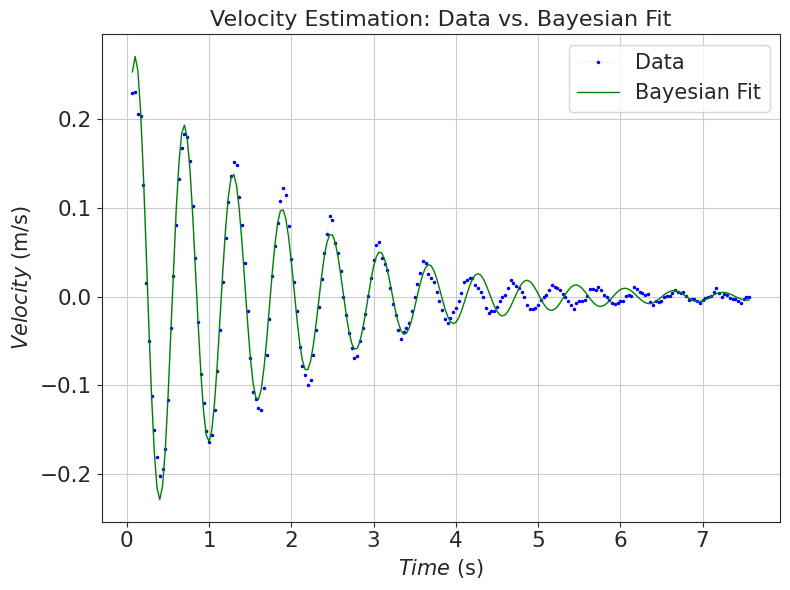

In [10]:
# Plot the observed velocity data versus the Bayesian fit

# Get the median of the fitted parameters
medians = np.array(fitted_parameters_vel)
medians_list = medians.tolist()

# Calculate the theoretical velocity using the fitted parameters
vbayes = vel_model(t, *fitted_parameters_vel)

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(t, v, color='blue', label='Data', marker='.', markersize=3.0, linewidth=0.05, ls='--')
plt.plot(t, vbayes, color='green', linewidth=1, label='Bayesian Fit')

# Set the labels and title
plt.xlabel(r'$Time$ (s)', fontsize=15)
plt.ylabel(r'$Velocity$ (m/s)', fontsize=15)
plt.title('Velocity Estimation: Data vs. Bayesian Fit', fontsize=16)
plt.legend(loc='upper right', fontsize=15)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

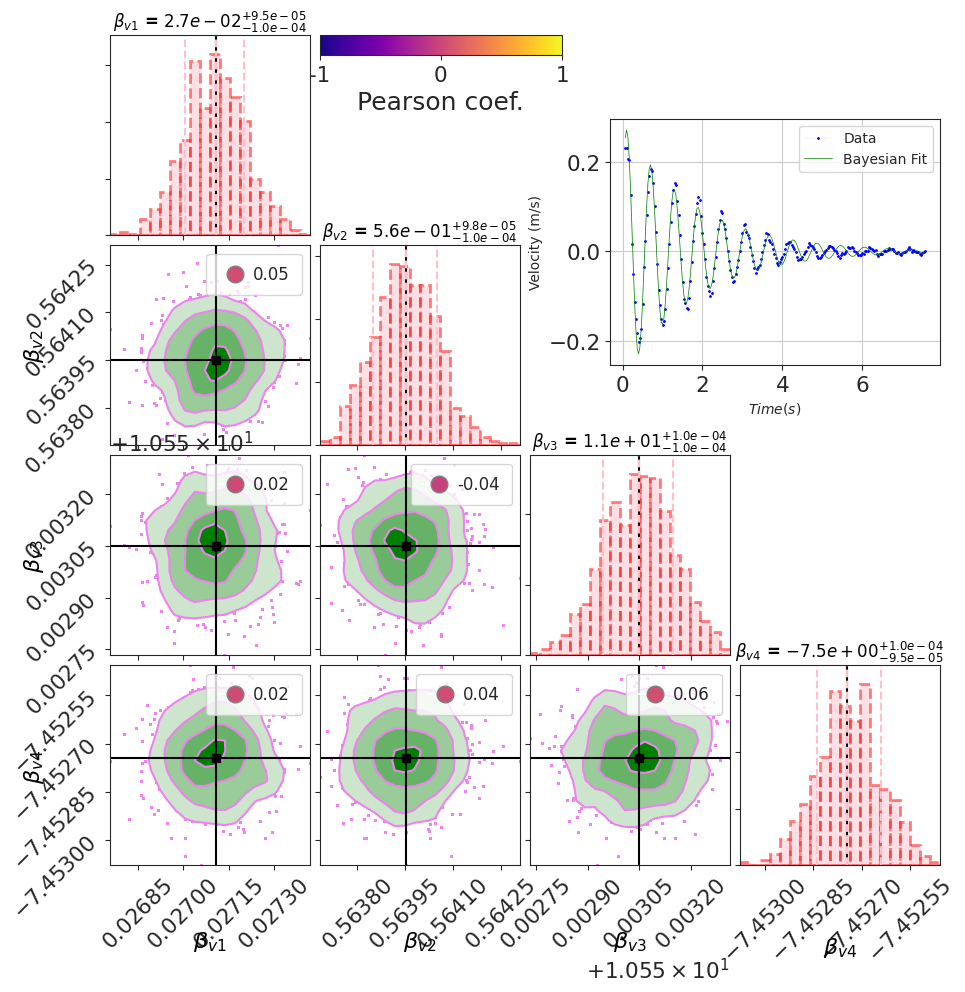

In [11]:
# Visualize the posterior distributions for velocity parameters using a corner plot

# Define the labels for the velocity parameters
labels_vel = [r'$\beta_{v1}$', r'$\beta_{v2}$', r'$\beta_{v3}$', r'$\beta_{v4}$']

# Create the corner plot
fig_vel = cornerHDR.corner(flat_samples_vel, labels=labels_vel, quantiles=[0.16, 0.5, 0.84],
    color="pink",
    show_titles=True,
    add_pvalue=True,
    plot_density=True,
    plot_contours=True,
    smooth=1.0,
    max_n_ticks=5,
    use_math_text=True,
    fill_contours=True,
    truths= medians_list,
    truth_color="black",
    title_fmt='.1e',
    color_hist="violet", color_dens="green",
    group="posterior",
    label_kwargs=label_kwargs,
    hist_kwargs={"color": "pink","edgecolor": "red","linestyle":"dashed", "linewidth": 2,"alpha": 0.5,"histtype":"barstacked"},
    title_kwargs={"fontsize": 12,"color": "Black", "fontweight": "bold"})

# Add an inset plot showing the velocity data and the fit
ax = plt.subplot2grid((10, 10), (1, 6), rowspan=3, colspan=4)
ax.plot(t, v, color='blue', label='Data', marker='.', markersize=2.0, linewidth=0.05, ls='--')
ax.plot(t, vbayes, color='green', linewidth=0.5, label='Bayesian Fit')
ax.set_xlabel(r'$Time (s)$')
ax.set_ylabel(r'Velocity (m/s)')
ax.legend()
ax.grid(True)

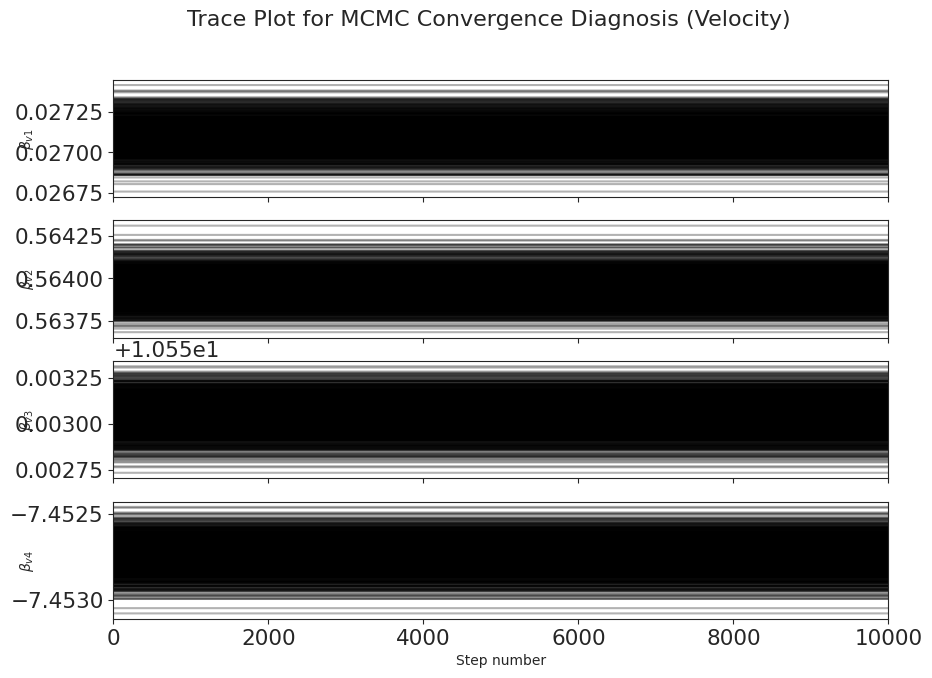

In [12]:
# Diagnose the convergence of the MCMC chains for velocity using a trace plot

# Create a figure with subplots for each velocity parameter
fig_vel, axes_vel = plt.subplots(ndim_vel, figsize=(10, 7), sharex=True)

# Plot the samples for each walker over the steps
for i in range(ndim_vel):
    ax = axes_vel[i]
    ax.plot(samples_vel[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples_vel))
    ax.set_ylabel(labels_vel[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

# Set the x-label for the last subplot
axes_vel[-1].set_xlabel("Step number")
# Add a title to the plot
plt.suptitle('Trace Plot for MCMC Convergence Diagnosis (Velocity)', fontsize=16)
plt.show()